In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorspacious import cspace_converter
import numpy as np
import pandas as pd
from makeitpop.derivatives import _calculate_derivatives
from makeitpop import makeitpop, update_derivatives, cmaps
import seaborn as sns
sns.set(font_scale=2, style='white')

derivatives, derivatives_scaled = update_derivatives(cmaps)

# Introducing _makeitpop_, a tool to perceptually warp your data!

> *Note: It should go without saying, but **you should never do the stuff that you're about to read about here**. Data is meant to speak for itself, and our visualizations should accurately reflect the data above all else.*

When I was in graduate school, I was known to get on my soapbox and tell everybody
why they should [stop using Jet](http://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/)
and adopt a "perceptually-flat" colormap like [viridis, magma, or inferno](https://bids.github.io/colormap/).

Surprisingly (ok, maybe not so surprisingly) I got a lot of pushback from people. One of the
most common responses was _"But I like **jet**, it really highlights my data, it makes the images 'pop' more effectively than viridis!"_.

It turns out that when a colormap "makes your data pop", it really just means "[warps your perception of the visualized data so that you detect non-linearities when there are none](https://bids.github.io/colormap/)". AKA, a colormap like Jet actually _mis-represents_ the data.

But what does this really mean? One of the challenges here is that it's difficult for people
to think about color - especially when it comes to relating color to objective relationships
between data.

Rather than talking about this in the abstract, what if we could *visualize* the warping that
is performed by colormaps like Jet?

We'll, I'm here to tell you that this is now possible. Introducing **`makeitpop`**.

## What does _makeitpop_ do?

Makeitpop lets you apply the same perceptual warping that would _normally_ be accomplished
with a colormap like Jet, but applies this warping to _the data itself_! This lets us
visualize it with a nice linear colormap like `viridis`!

For example, let's take a look at the [image demo in matplotlib](https://matplotlib.org/gallery/images_contours_and_fields/image_demo.html#sphx-glr-gallery-images-contours-and-fields-image-demo-py). In it, we create two blobs that are meant to be visualized as an image. Let's visualize this with our old friend viridis.

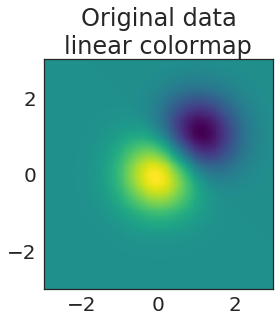

In [3]:
# Create our data
delta = 0.025
x = y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(Z, cmap=plt.cm.viridis,
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
ax.set(title="Original data\nlinear colormap")
plt.tight_layout()

Hmmm, not too bad...but it's a bit _boring_, no? Why can't we make it snazzier? I know, let's use Jet!

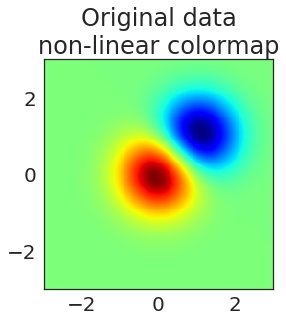

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(Z, cmap=plt.cm.jet,
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
ax.set(title="Original data\nnon-linear colormap")
plt.tight_layout()

Oooh now that's what I'm talking about. You can clearly see two peaks of significant results
at the center of each circle. Truly this is fit for publishing in _Nature_.

But...as you all know, this data only _looks_ better because we've used a colormap that distorts
our perception of the underlying data.

Let's illustrate this by **making it pop**!

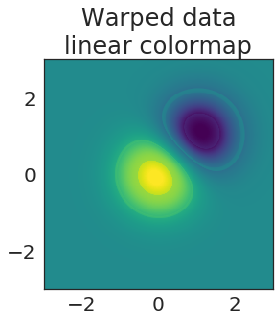

In [5]:
Z_popped = makeitpop(Z, 'jet', scaling_factor=20)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(Z_popped, cmap=plt.cm.viridis,
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
ax.set(title="Warped data\nlinear colormap")
plt.tight_layout()

Excellent! We're using a nice, perceptually-flat colormap like viridis, but we've attained
the same effect that Jet would have created!

Now let's visualize all three next to each other so that we can see the total effect:

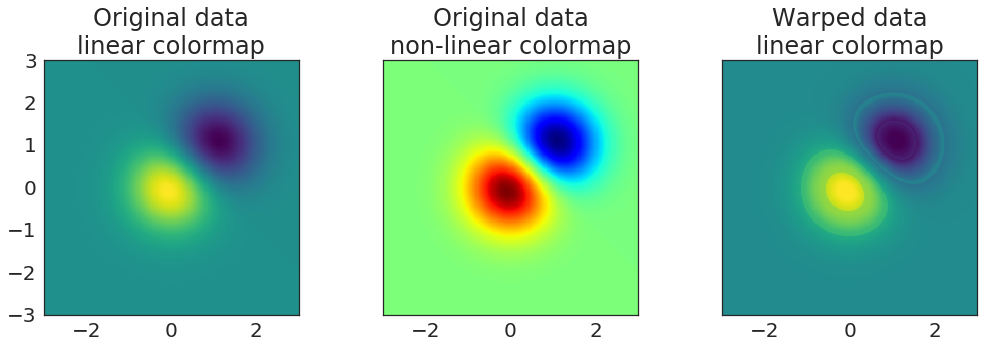

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

kws_img = dict(extent=[-3, 3, -3, 3], origin='lower',
               vmax=abs(Z).max(), vmin=-abs(Z).max())

axs[0].imshow(Z, cmap=plt.cm.viridis, **kws_img)
axs[0].set(title="Original data\nlinear colormap")

axs[1].imshow(Z, cmap=plt.cm.jet, **kws_img)
axs[1].set(title="Original data\nnon-linear colormap")

axs[2].imshow(Z_popped, cmap=plt.cm.viridis, **kws_img)
axs[2].set(title="Warped data\nlinear colormap")

plt.tight_layout()

## Let's see it in the real world

Thus far I've been using toy examples to illustrate how makeitpop works. Let's see how
things look on an actual dataset collected in the wild.

For this, we'll use the excellent [nilearn](https://nilearn.github.io/) package. This has a
few datasets we can download to demonstrate our point. First we'll load the data and prep it:

In [17]:
from nilearn import datasets
from nilearn import plotting
import nibabel as nb

tmap_filenames = datasets.fetch_localizer_button_task()['tmaps']
tmap_filename = tmap_filenames[0]

path = datasets.fetch_haxby_simple()
brain = nb.load(tmap_filename)
brain_data = brain.get_fdata()
mask = np.logical_or(brain_data < -.01, brain_data > .01)

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/numpy/lib/npyio.py:2266: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_haxby_simple is deprecated; fetch_haxby_simple will be removed in future releases. Use 'fetch_haxby' instead.
  warnings.warn(msg, category=DeprecationWarning)


Next, we'll create a "popped" version of the data, where we apply the non-linear warping
properties of Jet to our data, so that we can visualize the same effect in linear space.

In [18]:
brain_popped = brain_data.copy()
brain_popped[mask] = makeitpop(brain_popped[mask], colormap='jet', scaling_factor=75)
brain_popped = nb.Nifti1Image(brain_popped, brain.affine)

Now, I'll plot the results for each.

* First, we'll see the raw data on a linear colormap. This is the way we'd want to display the data if we _really_ wanted to show the true underlying relationships between datapoints.
* Next, we'll show the same data plotted with Jet. See how many more significant voxels there are! Here we come _Science_!
* Finally, we'll plot the "popped" data using a linear colormap (viridis). This accurately represents the underlying data, but the data _itself_ has been made to pop!

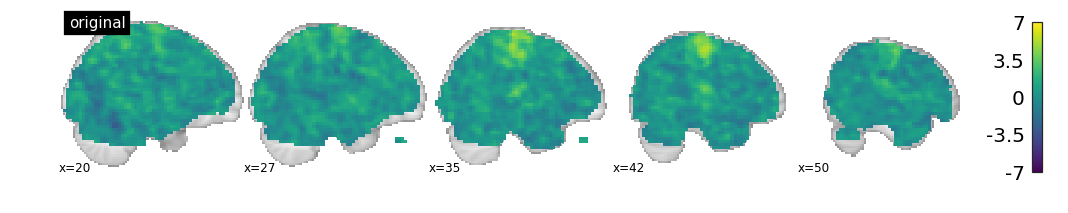

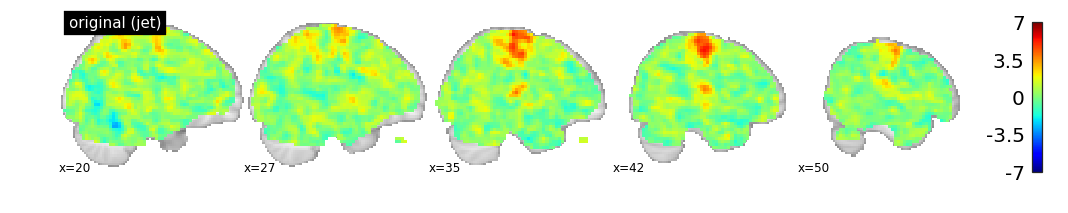

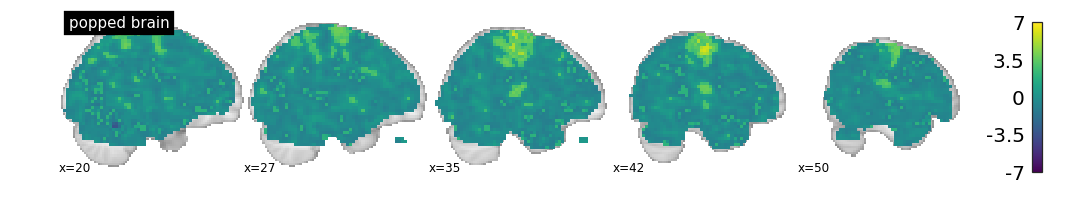

In [19]:
for i_brain, name in [(brain, 'original'), (brain, 'original (jet)'), (brain_popped, 'popped brain')]:
    cmap = 'jet' if name == 'original (jet)' else 'viridis'
    plotting.plot_stat_map(i_brain, cmap=cmap, vmax=7, display_mode='x',
                           title=name, cut_coords=np.linspace(20, 50, 5, dtype=int))

As you can see, different kinds of results begin to show up when your perception of the data is affected by the colormap.

## How does this work?

OK, so what is the black voodoo magic that makes it possible to "make your data pop"?

It all comes down to your visual system. I won't go into a ton of detail
because Nathaniel Smith and Stefan van der Walt [already gave a great talk about this](https://www.youtube.com/watch?v=xAoljeRJ3lU), however here is a lay-person's take:

When we use color to represent data, we are mapping a range of data values onto
a range of color values. Usually this means defining a min / max for our data, then mapping data
values linearly from 0 to 1, and finally mapping those values onto RGB values in a colormap.

Implicit in this process is the idea that stepping across our space in the _data_ will equate to
an equal step in our _perception_ of the color that is then chosen. We want a one-to-one mapping between the two.

Unfortunately, this isn't how our visual system works.

In reality, our brains do all kinds of strange things when interpreting color. They are biased to detect changes between particular kinds of colors, and biased to miss the transition between others.

Jet is particularly sensitive to this fact. It transitions through colors such that _linear_ changes in our data are perceived as _nonlinear_ changes when we look at the visualization. That's what makes the data "pop".

## Perceptual "delta" curves

You can determine the extent to which a colormap "warps" your perception of the data by calculating the "perceptual deltas" as you move across the values of a colormap (e.g. as you move from 0 to 1, and their corresponding colors).

These deltas essentially mean "how much is the _next_ color in the colormap perceived as different from the _current_ color?" If your colormap is perceptually flat, the delta will be the *same* no matter where you are on the range from 0 to 1.

Let's see what this delta looks like for Jet:

[Text(0.5,1,'Perceptual deltas with Jet')]

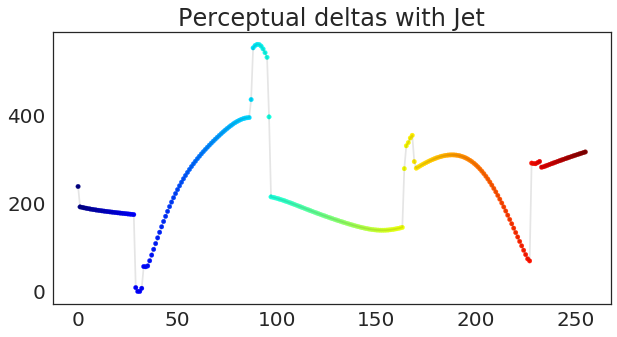

In [20]:
def plot_colormap_deltas(deltas, cmap, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    xrange = np.arange(len(derivatives))
    sc = ax.scatter(xrange, deltas, c=xrange, vmin=xrange.min(), vmax=xrange.max(),
                    cmap=plt.cm.get_cmap(cmap), s=20)
    ax.plot(xrange, deltas, c='k', alpha=.1)
    return ax

ax = plot_colormap_deltas(derivatives['jet'].values, 'jet')
ylim = ax.get_ylim()  # So we can compare with other colormaps
ax.set(title="Perceptual deltas with Jet")

Oops.

As you can see, Jet does **not** have a flat line for perceptual deltas. Each "jump" you see above is a moment where Jet is actually _mis-representing_ differences in the data. For shame, Jet.

Now let's see what this looks like for viridis:

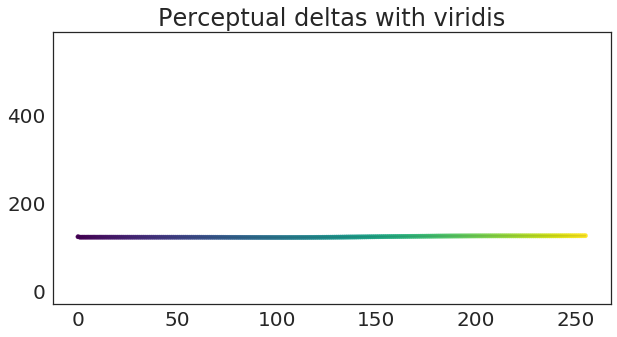

In [21]:
ax = plot_colormap_deltas(derivatives['viridis'].values, 'viridis')
ax.set(ylim=ylim, title="Perceptual deltas with viridis");

Ahhh, sweet, sweet linear representation of data.

In case you're curious, here are the "perceptual deltas" for several colormaps.
In this case, I've centered them and scaled each by the variance of the largest colormap,
so that they are easier to compare. 

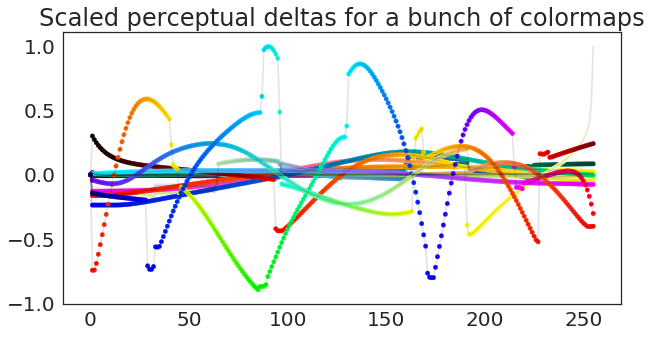

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
for cmap, deltas in derivatives_scaled.items():
    if cmap == 'linear':
        continue
    ax = plot_colormap_deltas(deltas.values, cmap, ax=ax)
ax.set(title="Scaled perceptual deltas for a bunch of colormaps");

## We can even warp 1-dimensional data!

Let's see how this principle affects our perception with a different kind of visual
encoding. Now that we know these perceptual warping functions, we can get all the
data-warping properties of jet, but in one dimension!

Here's a line.

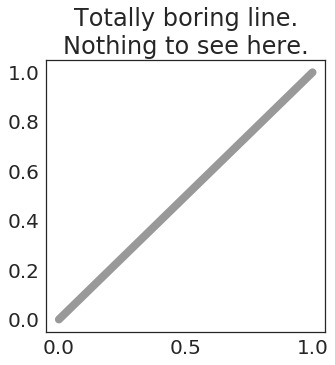

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(0, 1, 100)
ax.plot(x, x, 'k-', lw=8, alpha=.4, label='True Data')
ax.set_title('Totally boring line.\nNothing to see here.');

Ew. Boring.

Now, let's make it pop! We'll loop through a few colormaps, applying its color
warping function to the y-axis of our line as we step through it.

Text(0.5,1,'Making data "pop" is fun!')

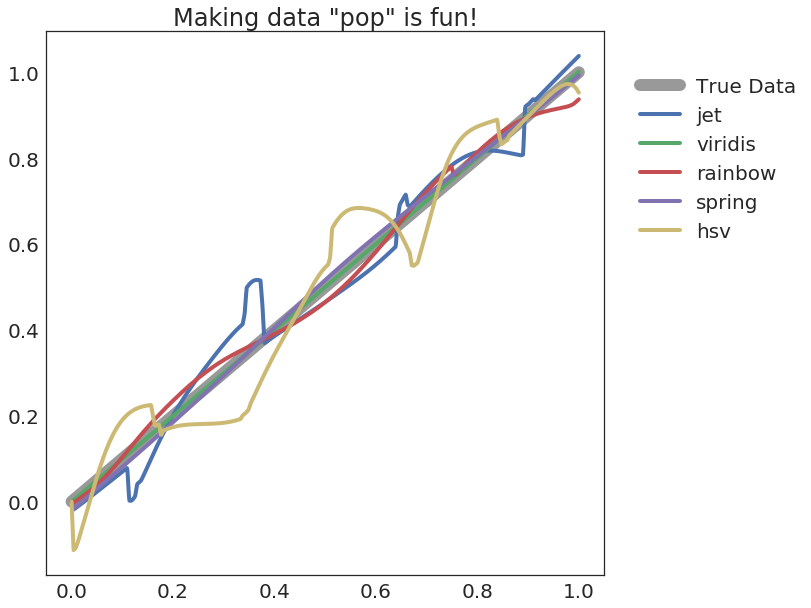

In [24]:
names = ['jet', 'viridis', 'rainbow', 'spring', 'hsv']
fig, ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 1, 1000)
ax.plot(x, x, 'k-', lw=12, alpha=.4, label='True Data')
for nm in names:
    ax.plot(x, makeitpop(x, colormap=nm, scaling_factor=40), label=nm, lw=4)
    ax.legend(loc=(1.05, .6))
ax.set_title('Making data "pop" is fun!')

As you can see, data looks much more interesting when it's been non-linearly warped!
It looks particularly striking when you see it on a 1-D plot. This is effectively
what colormaps such as Jet are doing in 2 dimensions! We're simply bringing the fun
back to 1-D space.

Let's see how it looks on some scatterplots. We'll plot the raw data in the background in grey,
and the "popped" data in front in color. Notice how some colormaps distort the y-values more
than others.

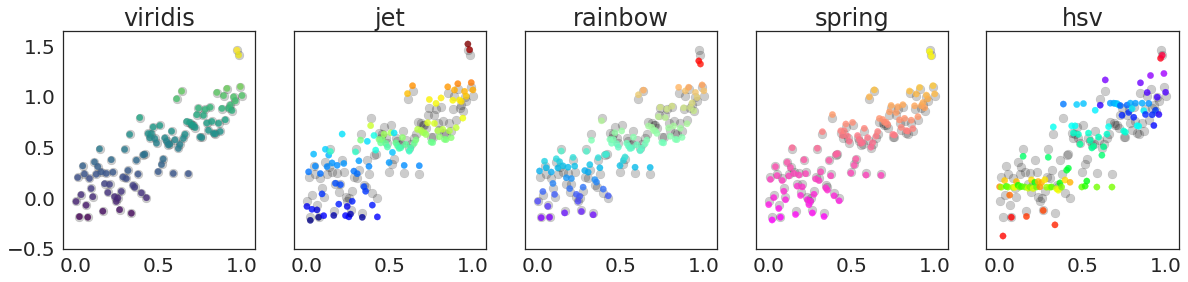

In [25]:
names = ['viridis', 'jet', 'rainbow', 'spring', 'hsv']
fig, axs = plt.subplots(1, len(names), figsize=(20, 4), sharex=True, sharey=True)
x = np.linspace(0, 1, 100)
y = x + np.random.randn(len(x)) * .2
for name, ax in zip(names, axs):    
    ax.scatter(x, y, c='k', s=80, alpha=.2)
    ax.scatter(x, makeitpop(y, name, 40), c=y, s=40, alpha=.8, cmap=plt.get_cmap(name))
    ax.set(title=name)


## So what now?

The reason that I wrote this blog post (and made this silly package) is to illustrate what we're really
doing when we use a colormap like Jet.  Sure, we want to choose the visualization that best-makes our point,
but a colormap like Jet is _actively mis-representing your data_. You'd _never_ consider changing the raw
data values so that an effect popped out, and you'd _never_ alter the y-values of a scatterplot so that something shows up. Well, this is perceptually what you're doing when you visualize 2-D data with Jet.

Here are a few things to keep in mind moving forward:

* Don't use Jet
* If you review a paper or are an editor for a journal, consider asking authors to use a perceptually flat colormap (this is usually just a matter of changing `cmap='viridis'`!
* In general, be aware of the effects that color has on the point you're trying to make. Perceptual warping is
  just one of many potential issues with choosing the right color.

## Wrapping up

I hope that this post has been a fun and slightly informative take on the nuances of colormaps, and the unintended effects that they might have when we use them to make statements about data.

So, `tl;dr`:

* Jet (and many other colormaps) mis-represent your perception of the data
* Perceptually flat colormaps like Viridis, Magma, Inferno, or Parula minimize this effect
* You can calculate the _extent_ to which this mis-representation happens as you move along the colormap
* We can then use this function to _distort_ data so that the data itself contains this mis-representation
* But doing so would be super unethical, so in the end **you should stop using jet and use a perceptually-flat colormap like viridis.**



If you'd like to check out the `makeitpop` package, see the [GitHub repo here](https://github.com/choldgraf/makeitpop). In addition, all of the examples in this post are runnable
on Binder! You can launch an interactive session with this code by clicking on the button below:

[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/choldgraf/makeitpop/master)


## Addendum: Ok but how does `makeitpop` _actually_ work?

In this section I'll describe the (admittedly hacky) way that I've written `makeitpop`.
As I mentioned before, [all the `makeitpop` code is on GitHub](https://github.com/choldgraf/makeitpop) and
Pull Requests are more than welcome to improve the process (looking at you "histogram matching" people!)

Here's what `makeitpop` does:

1. Collects a list of the "perceptual deltas". These are calculated from the equations given in [`viscm`](https://github.com/matplotlib/viscm), which was released as a part of the original work that created `viridis`.
2. Centers each colormap's deltas at 0.
3. Scales each colormap's deltas by the _largest variance_ across all colormaps. This is to make sure that warping the data is done with the relative differences of each colormap in mind.
4. When `makeitpop` is called, the function then:
    1. Scales the input data linearly between 0 and 1
    2. Calculates the point-by-point derivative for linearly spaced points between 0 and 1 (the derivative is the same for all points here).
    3. Multiplies each derivative by the scaled perceptual deltas function, plus an extra scaling factor that accentuates the effect.
    4. Adds each value to the scaled input data.
    5. Un-scale the altered input data so that it has the same min/max as before.
    
There are plenty of ways you could do this more effectively (for example, by matching empirical CDFs and
using linear interpolation to map the delta function of one colormap onto the delta function for another
colormap). If you'd like to contribute or suggest something, feel free to do so! However, I'm just creating
this package to highlight an idea, and think this approach gets close enough with relatively little complexity.


# Some extras

Here's a viz that will let you visualize how different colormaps distort data. We'll show a
gradient of linearly-spaced values, both using a warping colormap such as "jet" and a linear
colormap like "vidiris". Then, we'll "pop" the data and re-visualize with viridis.

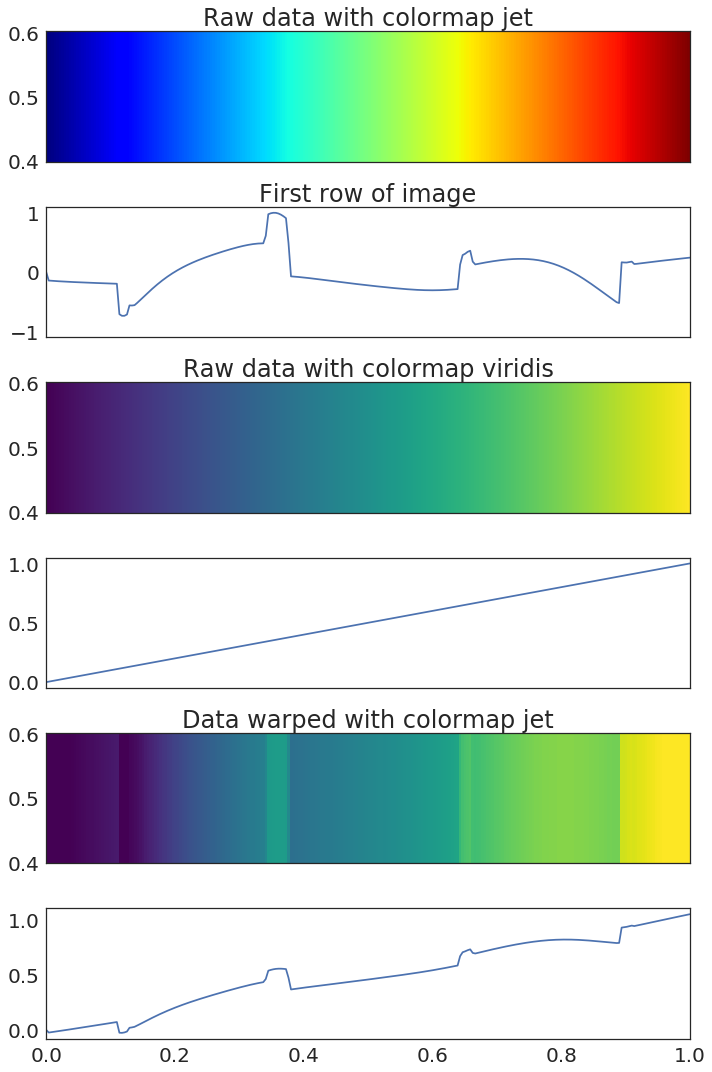

In [16]:
data = np.linspace(0, 1, 256)
data = np.tile(data, [100, 1])

cmap_warping = 'jet'
scaling_factor = 50
data_popped = makeitpop(data, cmap_warping, scaling_factor)

fig, axs = plt.subplots(6, 1, figsize=(10, 15), sharex=True)
axs[0].imshow(data, vmin=0, vmax=1, cmap=cmap_warping, extent=(0, 1, 0, 1))
axs[0].set(title="Raw data with colormap {}".format(cmap_warping))
axs[1].plot(derivatives_scaled.index, derivatives_scaled[cmap_warping].values)
axs[1].set(xlim=[0, 1], ylim=[-1.1, 1.1], title="First row of image")

axs[2].imshow(data, vmin=0, vmax=1, cmap='viridis', extent=(0, 1, 0, 1))
axs[2].set(title="Raw data with colormap {}".format('viridis'))
axs[3].plot(derivatives_scaled.index, data[0])
axs[3].set_xlim([0, 1])

axs[4].imshow(data_popped, vmin=0, vmax=1, cmap='viridis', extent=(0, 1, 0, 1))
axs[4].set(title="Data warped with colormap {}".format(cmap_warping))
axs[5].plot(derivatives_scaled.index, data_popped[0])
axs[5].set_xlim([0, 1])
plt.tight_layout()

And here's a little interactive widget to visualize how the scaling factor affects the "pop" effect.

In [26]:
from ipywidgets import interact, IntSlider, Dropdown

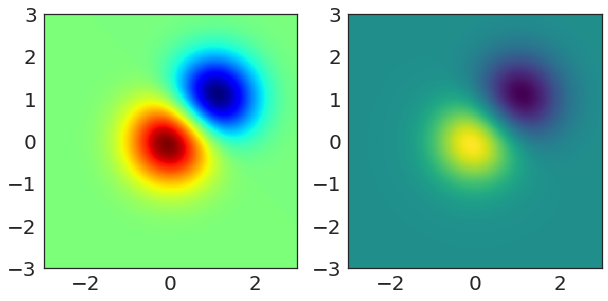

<function __main__.viz(scaling_factor, cmap)>

In [27]:
def viz(scaling_factor, cmap):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    Z_popped = makeitpop(Z, cmap, scaling_factor=scaling_factor)

    axs[0].imshow(Z, cmap=plt.get_cmap(cmap),
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
    axs[1].imshow(Z_popped, cmap=plt.cm.viridis,
              origin='lower', extent=[-3, 3, -3, 3],
              vmax=abs(Z).max(), vmin=-abs(Z).max())
    ax.set(title="Warped data\nlinear colormap")
    plt.show()
interact(viz, scaling_factor=IntSlider(1, 1, 80),
         cmap=Dropdown(options=derivatives_scaled.columns.values, value='jet'))